In [382]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader, random_split,Dataset, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from sklearn.model_selection import train_test_split

## Preparing Data

In [383]:
transform=transforms.Compose([transforms.ToTensor()])

In [384]:
mnist_train = datasets.MNIST(root='./data', train=True, transform=transform, download=False)
mnist_test = datasets.MNIST(root='./data', train=False, download=False, transform=transform)

In [385]:
data =mnist_train.data.numpy().astype(np.float32)/255.0
labels=mnist_train.targets.numpy()

In [386]:
data=data.reshape(data.shape[0],-1) 

In [387]:
data_train,data_temp,labels_train,labels_temp=train_test_split(data,labels,test_size=0.4,random_state=42,stratify=labels)
data_val,data_test,labels_val,labels_test=train_test_split(data_temp,labels_temp,test_size=0.5,random_state=42,stratify=labels_temp)

In [388]:
print("train:",data_train.shape,labels_train.shape)
print("val:",data_val.shape,labels_val.shape)
print("test:",data_test.shape,labels_test.shape)

train: (36000, 784) (36000,)
val: (12000, 784) (12000,)
test: (12000, 784) (12000,)


In [389]:
data_train_tensor=torch.tensor(data_train)
labels_train_tensor=torch.tensor(labels_train,dtype=torch.long)

data_val_tensor=torch.tensor(data_val)
labels_val_tensor=torch.tensor(labels_val,dtype=torch.long)

data_test_tensor=torch.tensor(data_test)
labels_test_tensor=torch.tensor(labels_test,dtype=torch.long)

In [390]:
trainig_dataset=TensorDataset(data_train_tensor,labels_train_tensor)
validation_dataset=TensorDataset(data_val_tensor,labels_val_tensor)
testing_dataset=TensorDataset(data_test_tensor,labels_test_tensor)

In [391]:
training_loader=DataLoader(trainig_dataset,batch_size=64,shuffle=True)
validation_loader=DataLoader(validation_dataset,batch_size=64,shuffle=False)
testing_loader=DataLoader(testing_dataset,batch_size=64,shuffle=False)

# Logistic Regression 

### 1. Binary Logistic Regression

In [392]:
zero_one_training=(labels_train_tensor==0)|(labels_train_tensor==1)
zero_one_validation=(labels_val_tensor==0)|(labels_val_tensor==1)


In [393]:
data_trianing_binary=data_train_tensor[zero_one_training]
labels_training_binary=labels_train_tensor[zero_one_training].unsqueeze(1)

In [394]:
data_validation_binary=data_val_tensor[zero_one_validation]
labels_validation_binary=labels_val_tensor[zero_one_validation].unsqueeze(1)

In [395]:
number_of_features=data_trianing_binary.shape[1] #number of input pixels
W=torch.zeros((number_of_features,1),requires_grad=True)
b=torch.zeros(1,requires_grad=True)

lr=0.01
num_epochs=1000 #how many times to iterate over the training set

In [396]:
def segmoid(z):
    return 1/(1+torch.exp(-z))

In [397]:
def linear_output(X,W,b):
    return torch.matmul(X,W) +b

In [398]:
training_losses=[]
validation_losses=[]
training_accuracies=[]
validation_accuracies=[]

In [399]:
for epoch in range(num_epochs):
    #Forward pass
    linear_out=linear_output(data_trianing_binary,W,b)
    labels_predection=segmoid(linear_out)
    
    #Compute loss
    training_loss = -torch.mean(labels_training_binary*torch.log(labels_predection)+(1-labels_training_binary)*torch.log(1-labels_predection)) 
    
    #training accuracy
    labels_training_predection=(labels_predection>=0.5).float()
    training_accuracy=torch.mean((labels_training_predection==labels_training_binary).float())

    # validattion pass
    with torch.no_grad():
        linear_out_val=linear_output(data_validation_binary,W,b)
        labels_predection_val=segmoid(linear_out_val)
        
        #Compute validation loss
        validation_loss = -torch.mean(labels_validation_binary*torch.log(labels_predection_val)+(1-labels_validation_binary)*torch.log(1-labels_predection_val)) 
        
        #validation accuracy
        labels_validation_predection=(labels_predection_val>=0.5).float()
        validation_accuracy=torch.mean((labels_validation_predection==labels_validation_binary).float())
    #Backward pass on training loss
    training_loss.backward()
    #Update weights
    with torch.no_grad():
        W-=lr*W.grad
        b-=lr*b.grad

    # Reset gradients
    W.grad.zero_()
    b.grad.zero_()
    
    # Store losses and accuracies
    training_losses.append(training_loss.item())
    validation_losses.append(validation_loss.item())
    training_accuracies.append(training_accuracy.item())
    validation_accuracies.append(validation_accuracy.item())
    if (epoch+1)%100==0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {training_loss.item():.4f}')

Epoch [100/1000], Loss: 0.1201
Epoch [200/1000], Loss: 0.0701
Epoch [300/1000], Loss: 0.0515
Epoch [400/1000], Loss: 0.0416
Epoch [500/1000], Loss: 0.0354
Epoch [600/1000], Loss: 0.0311
Epoch [700/1000], Loss: 0.0280
Epoch [800/1000], Loss: 0.0255
Epoch [900/1000], Loss: 0.0236
Epoch [1000/1000], Loss: 0.0220


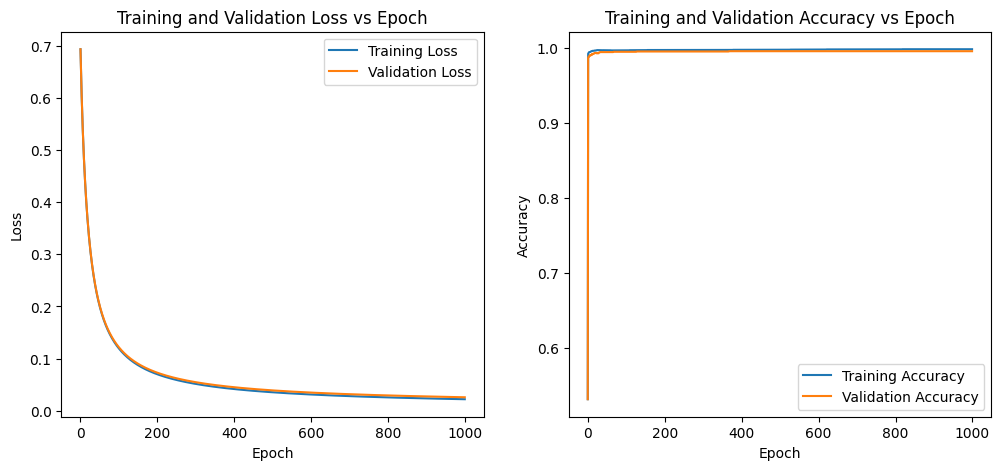

In [400]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(training_losses,label='Training Loss')
plt.plot(validation_losses,label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss vs Epoch')
plt.legend()

plt.subplot(1,2,2)
plt.plot(training_accuracies,label='Training Accuracy')
plt.plot(validation_accuracies,label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy vs Epoch')
plt.legend()

plt.show()

### Final Test Accuracy

In [401]:
with torch.no_grad():
    zero_one_testing=(labels_test_tensor==0)|(labels_test_tensor==1)
    data_testing_binary=data_test_tensor[zero_one_testing]
    labels_testing_binary=labels_test_tensor[zero_one_testing].unsqueeze(1)

    linear_out_test=linear_output(data_testing_binary,W,b)
    labels_predection_test=segmoid(linear_out_test)

    labels_testing_predection_class=(labels_predection_test>=0.5).float() 
    test_accuracy=torch.mean((labels_testing_predection_class==labels_testing_binary).float())

print(f'Test Accuracy: {test_accuracy.item()*100:.2f}%')

Test Accuracy: 99.84%


### Confusion Matrix

In [402]:
confusion_matrix=torch.zeros(2,2,dtype=torch.int32)
with torch.no_grad():
    for true_label, pred_label in zip(labels_testing_binary, labels_testing_predection_class):
        confusion_matrix[int(true_label.item()), int(pred_label.item())] += 1


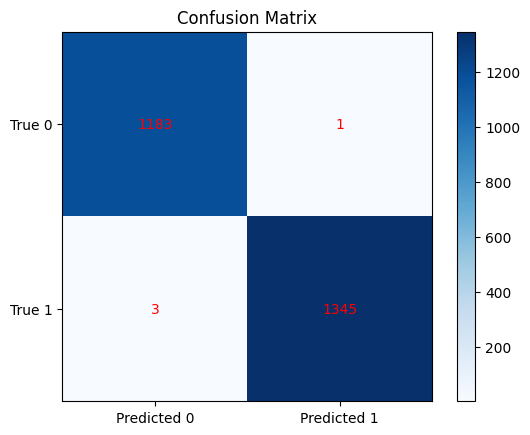

In [403]:
plt.imshow(confusion_matrix, cmap='Blues')
plt.title('Confusion Matrix')
plt.colorbar()
plt.xticks([0, 1], labels=['Predicted 0', 'Predicted 1'])
plt.yticks([0, 1], labels=['True 0', 'True 1'])

for i in range(2):
    for j in range(2):
        plt.text(j, i, confusion_matrix[i, j].item(), ha='center', va='center', color='red')

plt.show()